# Introduction

Most people spend a large part of their adult lives to work in paid jobs. Therefore, the quality of employment is significantly associated with individual well-being and life satisfaction. For organizations, though it tends to be costly to create high-quality jobs, the initial investments can eventually pay off with higher productivity. Therefore, identifying the core components of job quality and improving working conditions are of interests to both parties: employers and employees. 

With that in mind, this project has three main objectives:

- Identify important determinants of job quality with the help of multiple linear regression analysis and descriptive statistics.
- Apply canonical correlation analysis to identify possible relationships between socio-demographic/personality characteristics and job features.
- Examine levels of job satisfaction in different personality groups with cluster analysis.

## Key components of a good job

A good job should consist of various aspects of working conditions that bring positive improvements to employees. According to [Holman (2013)](https://journals.sagepub.com/doi/10.1177/0018726712456407), there are five main aspects of job quality:
- **Wage and payment system**: Salaries, wages, financial compensations, wage increases, and fringe benefits. 
- **Security and flexibility**: Type of contract and working hours.
- **Work organization**: Job resources (autonomy, rotation, teamwork, communication, structures) and job demands (deadlines, workload, physical conditions). 
- **Skills and development**: On-the-job training programs or training courses. 
- **Engagement**: Regular meetings, feedback, and consultations.

## Personality and socio-demographics

The notion of a "good" or "bad" job may vary from person to person, depending on their expectation and standards. For instance, young employees may expect a job with more autonomy, flexible environments, and many opportunities to learn, while older workers may put more importance on fewer working hours and more security. 

Two relevant proxies can help quantify individuals' expectations at work:
- **Socio-demographic factors**: age, gender, level of education, level of household income, migration background.  
- **Personality traits**: The Big Five is one of the most popular models to measure differences in personality traits. It states that there are five fundamental dimensions of human personality: 
    -  *Conscientiousness*: thorough, responsible, reliable, planful, organized, and efficient. 
    - *Neuroticism*: emotional instability and a tendency to experience negative feelings. 
    - *Openness to experience*: a need for change and variety. 
    - *Extraversion*: social skills, assertiveness, and emotional expressiveness. 
    - *Agreeableness*: appreciativeness, generosity, kindness, affection, and sympathy.

# Data overview and transformation

The data in this reasearch was extracted from the [SOEP-CORE.v36](https://paneldata.org/soep-core/), a longitudinal study conducted by the German Institute for Economic Research (DIW Berlin) and involved more than 30,000 individuals and 15,000 households in Germany since 1984. The original package contains 15.5 GB of data with 59 datasets on various topics.

After completing [initial research](https://paneldata.org/search/all?Study=%5B%22SOEP-Core%22%5D), I determined 4 necessary datasets with relevant data for the project:
- PGEN: personal-related variables
- PL: personal-related original data
- HGEN: household-related variables
- PPATHL: personal-related meta dataset

## Import data

In [ ]:
import numpy as np
import pandas as pd
import os
from functools import reduce # for merging 
from plotnine import *
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA
from sklearn.cluster import KMeans
import statsmodels.api as sm

# change the working directory
os.chdir("../good-job/data")

All datasets are in the `.dta` extension, so I use `read_stata` to import them. For the `pl` and `big5` datasets, because the original file is very large (almost 5GB), I used Stata to pre-selected the necessart variables and exported into the `.csv` file for quicker importing.

Though the SOEP contains annual data, I restrict the sample to the year 2001 due to the availability of information about job satisfaction. The only exception is the data for personality traits, which are only available from the year 2005 onward. Researchers have shown that the development of human personality is relatively constant across the life span, so this approach is reasonable.

In [2]:
# import pgen dataset, select relevant variables, and filter to year 2001
pgen = (pd.read_stata("pgen.dta", columns = ['syear', 'pid', 'hid', 'pgbilzeit', 'pglabnet', 'pgemplst', 'pgtatzeit', 'pguebstd', 'pgmps92', 'pgexpft', 'pgexppt', 'pgexpue'])
             .query('syear == 2001'))
# import hgen dataset 
hgen = (pd.read_stata("hgen.dta", columns = ['syear', 'hid', 'hghinc'])
        .query('syear == 2001'))
# import ppathl dataset
ppathl = (pd.read_stata("ppathl.dta", columns = ['syear', 'pid', 'sex', 'gebjahr', 'migback'])
         .query('syear == 2001'))
# import pl dataset, columns were pre-selected in Stata
pl = (pd.read_csv("pl.csv")
      .query('syear == 2001'))
# import big 5 personality dataset, columns were pre-selected in Stata
big5 = (pd.read_csv("big5.csv")
        .query('syear == 2005'))

## Merge data

Once all datasets are imported, it's time to combine them into one single dataframe. `pgen` is merged with `hgen` on the `hid` key (household id), and then with other datasets on `pid` key (personal id). After merging, I drop unnecessary variables and rename columns for easier interpretations.  

In [ ]:
# Merge pgen and hgen on `hid` key
pgen_hgen = pd.merge(pgen, hgen, on = "hid", how = "inner")

# Merge pgen_hgen with other datasets on `pid` key
df_merge = [pgen_hgen, ppathl, big5, pl]
good_job = (reduce(lambda left,right: pd.merge(left,right, 
                                               on=['pid'], 
                                               how ='inner'), df_merge)
            .drop(['syear', 'syear_x', 'syear_y', 'hid', 'pid'], axis = 1)
            #rename columns
            .set_axis(['training', 'net_income', 'full_time', 'work_time', 'overtime', 'job_status', 'full_exp', 
                    'part_exp', 'unemp_exp', 'house_income', 'male', 'birthyear', 'migration', 'reserved','sociable',
                    'stress','worry','efficient','thorough','imagination','friendly','forgive', 'job_satisfaction','permanent',
                    'varied_job','manual_labor','self_decide','work_control','shift','boss_conflict','colleague','learning','hazardous','stress_level','accident'
                      ], axis = 1)
            #rearrange columns in groups
            .loc[:,['birthyear','male','house_income','migration','training','full_exp','part_exp','unemp_exp',
                    'efficient','forgive','friendly','imagination','reserved','sociable','stress','thorough','worry',
                    'full_time','job_status','net_income','permanent','overtime','work_time',
                    'job_satisfaction','accident','boss_conflict','colleague','work_control','hazardous','learning','manual_labor','self_decide','shift','stress_level','varied_job']]
           )

## Transform data

Let's take a look at the combined dataset:

In [4]:
good_job.head()

birthyear           male house_income                           migration  \
0       1926   [2] weiblich          614      [1] kein Migrationshintergrund   
1       1960  [1] maennlich         1892      [1] kein Migrationshintergrund   
2       1958   [2] weiblich         8181  [2] direkter Migrationshintergrund   
3       1958   [2] weiblich         4897      [1] kein Migrationshintergrund   
4       1951   [2] weiblich         1176      [1] kein Migrationshintergrund   

  training full_exp part_exp unemp_exp            efficient  \
0     10.5      4.0      0.0       0.0  [5] 5 auf Skala 1-7   
1     18.0    3.667      5.5     3.667  [5] 5 auf Skala 1-7   
2     12.0   17.917     0.25       0.5  [6] 6 auf Skala 1-7   
3     18.0    5.833    8.167     0.333  [3] 3 auf Skala 1-7   
4     10.5    29.25      2.0       0.0  [5] 5 auf Skala 1-7   

               forgive  ...            boss_conflict             colleague  \
0   [7] Trifft voll zu  ...     [-2] trifft nicht zu  [-2] trifft nicht zu   
1  [4] 4 auf Skala 1-7  ...  [2] Trifft teilweise zu    [1] Trifft voll zu   
2  [5] 5 auf Skala 1-7  ...      [3] Trifft nicht zu    [1] Trifft voll zu   
3  [4] 4 auf Skala 1-7  ...     [-2] trifft nicht zu  [-2] trifft nicht zu   
4  [5] 5 auf Skala 1-7  ...      [3] Trifft nicht zu    [1] Trifft voll zu   

           work_control             hazardous                 learning  \
0  [-2] trifft nicht zu  [-2] trifft nicht zu     [-2] trifft nicht zu   
1   [3] Trifft nicht zu   [3] Trifft nicht zu       [1] Trifft voll zu   
2   [3] Trifft nicht zu    [1] Trifft voll zu      [3] Trifft nicht zu   
3  [-2] trifft nicht zu  [-2] trifft nicht zu     [-2] trifft nicht zu   
4     [-1] keine Angabe   [3] Trifft nicht zu  [2] Trifft teilweise zu   

           manual_labor              self_decide                    shift  \
0  [-2] trifft nicht zu     [-2] trifft nicht zu     [-2] trifft nicht zu   
1   [3] Trifft nicht zu  [2] Trifft teilweise zu      [3] Trifft nicht zu   
2   [3] Trifft nicht zu       [1] Trifft voll zu      [3] Trifft nicht zu   
3  [-2] trifft nicht zu     [-2] trifft nicht zu     [-2] trifft nicht zu   
4    [1] Trifft voll zu  [2] Trifft teilweise zu  [2] Trifft teilweise zu   

              stress_level               varied_job  
0     [-2] trifft nicht zu     [-2] trifft nicht zu  
1       [1] Trifft voll zu       [1] Trifft voll zu  
2      [3] Trifft nicht zu  [2] Trifft teilweise zu  
3     [-2] trifft nicht zu     [-2] trifft nicht zu  
4  [2] Trifft teilweise zu       [1] Trifft voll zu  

[5 rows x 35 columns]

In [5]:
good_job.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16748 entries, 0 to 16747
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   birthyear         16748 non-null  int16   
 1   male              16748 non-null  category
 2   house_income      16748 non-null  category
 3   migration         16748 non-null  category
 4   training          16748 non-null  category
 5   full_exp          16748 non-null  category
 6   part_exp          16748 non-null  category
 7   unemp_exp         16748 non-null  category
 8   efficient         16748 non-null  object  
 9   forgive           16748 non-null  object  
 10  friendly          16748 non-null  object  
 11  imagination       16748 non-null  object  
 12  reserved          16748 non-null  object  
 13  sociable          16748 non-null  object  
 14  stress            16748 non-null  object  
 15  thorough          16748 non-null  object  
 16  worry             1674

The `good_job` dataset contains 16,748 observations and 35 columns. Since data come from surveys in the raw formats, it is necesasry to clean and transform them before analysis. 

In [6]:
# Invalue data to remove
invalid_value = ['[-1] keine Angabe', "[-2] trifft nicht zu", "[-3] nicht valide", "[-4] Unzulaessige Mehrfachantwort", "[-5] in Fragebogenversion nicht enthalten", "[-6] Fragebogenversion mit geaenderter Filterfuehrung", "[-7] Only available in less restricted edition", "[-8] Frage in diesem Jahr nicht Teil des Frageprogramms"]

# String values to transform into numeric values
big5_transform = {'[1] Trifft ueberhaupt nicht zu': 1, '[2] 2 auf Skala 1-7': 2, '[3] 3 auf Skala 1-7': 3, '[4] 4 auf Skala 1-7': 4,'[5] 5 auf Skala 1-7': 5, '[6] 6 auf Skala 1-7': 6,'[7] Trifft voll zu': 7}
thorough_transform = {'[1] Trifft ueberhaupt nicht zu': 1, '[2] 2 auf Skala 1-7': 2, '[3] auf einer Skala 1-7': 3,'[4] auf einer Skala 1-7': 4, '[5] auf einer Skala 1-7': 5, '[6] auf einer Skala 1-7':6,'[7] Trifft voll zu':7}
job_satisfaction_transform = {
        '[0] 0 Zufrieden: Skala 0-Niedrig bis 10-Hoch':0,
        '[1] 1 Zufrieden: Skala 0-Niedrig bis 10-Hoch':1,
        '[2] 2 Zufrieden: Skala 0-Niedrig bis 10-Hoch':2,
        '[3] 3 Zufrieden: Skala 0-Niedrig bis 10-Hoch':3,                                            
        '[4] 4 Zufrieden: Skala 0-Niedrig bis 10-Hoch':4,
        '[5] 5 Zufrieden: Skala 0-Niedrig bis 10-Hoch':5,                       
        '[6] 6 Zufrieden: Skala 0-Niedrig bis 10-Hoch':6, 
        '[7] 7 Zufrieden: Skala 0-Niedrig bis 10-Hoch':7,
        '[8] 8 Zufrieden: Skala 0-Niedrig bis 10-Hoch':8,
        '[9] 9 Zufrieden: Skala 0-Niedrig bis 10-Hoch':9,
        '[10] 10 Zufrieden: Skala 0-Niedrig bis 10-Hoch':10}
job_feature_transform = {'[3] Trifft nicht zu':0, '[2] Trifft teilweise zu':1, '[1] Trifft voll zu':1}

good_job_final = (good_job.loc[(~good_job.iloc[:,:].isin(invalid_value)).all(axis=1),:]
    # transform category columns into numeric  
    .assign(
          training     = good_job['training'].apply(pd.to_numeric, errors='coerce'),
          work_time    = good_job['work_time'].apply(pd.to_numeric, errors='coerce'),
          job_status   = good_job['job_status'].apply(pd.to_numeric, errors='coerce'),
          full_exp     = good_job['full_exp'].apply(pd.to_numeric, errors='coerce'),
          part_exp     = good_job['part_exp'].apply(pd.to_numeric, errors='coerce'),
          unemp_exp    = good_job['unemp_exp'].apply(pd.to_numeric, errors='coerce'),
          net_income   = good_job['net_income'].apply(pd.to_numeric, errors='coerce'),
          house_income = good_job['house_income'].apply(pd.to_numeric, errors='coerce'),
          full_time    = good_job['full_time'].map({"[1] Voll erwerbstätig": 1, "[2] Teilzeitbeschäftigung": 0,"[3] Ausbildung, Lehre": 0,"[4] Unregelmässig, geringfügig erwerbstät.": 0,"[6] Werkstatt für behinderte Menschen": 1}),
          overtime     = good_job['overtime'].replace({"[0] keine Ueberstunden letzten Monat":0}).apply(pd.to_numeric, errors='coerce'),
          male         = good_job['male'].map({'[1] maennlich':1, '[2] weiblich':0}),
          migration    = good_job['migration'].map({'[1] kein Migrationshintergrund': 0, "[2] direkter Migrationshintergrund": 1, "[3] indirekter Migrationshintergrund":1 })
      )
    # filter  
    .query('birthyear > 0 & house_income > 0 & house_income < 10000 & net_income > 0')
    .dropna()
    # transform personality and job features into numeric values
    .replace({'reserved': big5_transform, 'sociable': big5_transform,'stress':big5_transform,
              'worry':big5_transform,'efficient':big5_transform,'thorough':thorough_transform,
              'imagination':big5_transform,'friendly':big5_transform,'forgive':big5_transform,
              'job_satisfaction':job_satisfaction_transform,
              'permanent': {'[1] Unbefristet':1, '[2] Befristet':0, '[3] T.n.z., kein Arbeitsvertrag':0},
              'varied_job': job_feature_transform,'manual_labor': job_feature_transform,
              'self_decide': job_feature_transform,'work_control': job_feature_transform,
              'shift': job_feature_transform,'boss_conflict': job_feature_transform,
              'colleague': job_feature_transform,'learning': job_feature_transform,
              'hazardous': job_feature_transform,'stress_level': job_feature_transform,
              'accident': job_feature_transform,
             }
            )
)

# Descriptive statistics

In [7]:
good_job_final.shape

(7513, 35)

The final sample for analysis consists of 7,517 individuals with 35 variables in total. The table belows represents more details about descriptive statistics of all variables. 


In [8]:
(good_job_final.describe()
 .transpose()
 .loc[:,['min','mean','max','std']]
 .style.format('{:,.2f}'))

The dependent variable in the analysis is job satisfaction, which is measured on a scalar scale from 0 (totally dissatisfied) to 10 (totally satisfied). On average, most individuals are satisfied with their job (mean = 7.15). Other variables are divided into 3 groups for further analysis: 

**Socio-demographic** (`birthyear` to `part_exp`) **and personality** (`efficient` to `worry`) **features** 

The sample consists of a relatively equal proportion of male and female participants who are in the prime phases of their working lives with the average age at 41 and well trained or educated (12.2 years). A relative fraction of employees with a migration background is included, which represents the increasing importance of migrants to the German economy and society. The average monthly household income is about €2563, which is slightly below the national level at €2646 in 2001. 

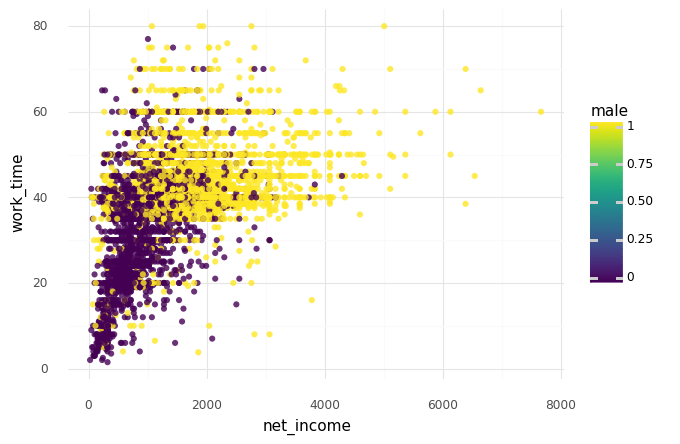

<ggplot: (8788334826478)>

In [9]:
# Differences in income level and work time between men and women
(ggplot (good_job_final, aes(x = 'net_income', y = 'work_time', fill = 'male')) + 
 geom_point(size = 2.5, stroke = 0, alpha = 0.8) +
 theme_minimal())

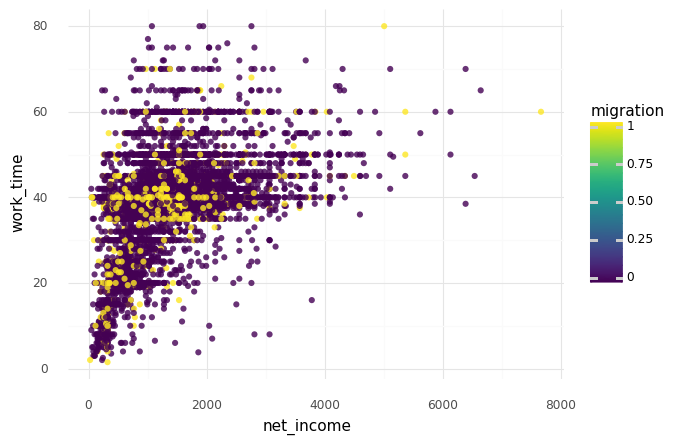

<ggplot: (8788282130701)>

In [10]:
# Differences in income level and work time between migrant and native employees
(ggplot (good_job_final, aes(x = 'net_income', y = 'work_time', fill = 'migration')) + 
 geom_point(size = 2.5, stroke = 0, alpha = 0.8) +
 theme_minimal())

9 personality variables associated with the Big Five model are included: efficient and thorough (conscientiousness), forgive and friendly (agreeableness), stress and worry (neuroticism), reserved and sociable (extraversion), and imagination (openness to experience). Respondents rated their temperaments themselves on a scale from 1 (not agree) to 7 (compltely agree). Based on descriptive statistics, individuals in the sample receive high scores on most traits, especially thorough, efficient, friendly, forgive, and sociable.

**Objective job features** (`full_time` to `work_time`)

The data includes 6 objective aspects of employment that are not affected by the respondents’ opinions or feelings. Overall, most people have a full-time job with a permanent contract, 38.53 working hours and 2.21 overtime hours per week. The job_status shows the perceived perception of the general public on the occupations. In this project, it is represented by the magnitude prestige scale (MPS) developed by Wegener (1988), which ranges from 30 (low prestige) to 216 (high prestige). Lastly, the monthly net income is around €1373/month on average.

**Subjective job features** (`accident` to `varied_job`)

Subjective job features are coded into dummy variables with 0 (not agree) and 1 (agree). Overall most respondents have relatively good working conditions with a very high level of task diversity (0.94), good relationships with colleagues (0.97), great degrees of autonomy at work (0.83), and many opportunities to learn (0.81). In contrast, their jobs are involved high levels of stress (0.79) and a relative fraction is strictly monitored (0.62). The manual_labor indicates that the ratio of blue-collar to white-collar employees is quite equal. For physical conditions, most people does not have to work in hazardous environments or jobs with high risks of accidents.

# What affects job satisfactions?

To identify which factors determine job quality, the following multiple regression model is used: $Job\_satisfaction_i = \beta X_i + u_i$. Using ordinary least squares (OLS) for estimation, this model can help determine statically significant variables and the signs of their effects.

In [11]:
X = good_job_final.loc[:, good_job_final.columns != 'job_satisfaction']
y = good_job_final.job_satisfaction
mod = sm.OLS(y,X)
fii = mod.fit()
fii.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       job_satisfaction   R-squared (uncentered):                   0.941
Model:                            OLS   Adj. R-squared (uncentered):              0.941
Method:                 Least Squares   F-statistic:                              3536.
Date:                Tue, 20 Sep 2022   Prob (F-statistic):                        0.00
Time:                        18:45:57   Log-Likelihood:                         -15059.
No. Observations:                7513   AIC:                                  3.019e+04
Df Residuals:                    7479   BIC:                                  3.042e+04
Df Model:                          34                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
birthyear         0.0026      0.000     17.564      0.000       0.002       0.003
male              0.1141      0.055      2.089      0.037       0.007       0.221
house_income   8.584e-05    2.3e-05      3.726      0.000    4.07e-05       0.000
migration         0.2231      0.060      3.733      0.000       0.106       0.340
training         -0.0399      0.012     -3.393      0.001      -0.063      -0.017
full_exp         -0.0068      0.002     -3.143      0.002      -0.011      -0.003
part_exp         -0.0073      0.005     -1.356      0.175      -0.018       0.003
unemp_exp        -0.0428      0.018     -2.391      0.017      -0.078      -0.008
efficient         0.0861      0.024      3.552      0.000       0.039       0.134
forgive           0.0638      0.017      3.702      0.000       0.030       0.098
friendly          0.0182      0.023      0.809      0.418      -0.026       0.062
imagination       0.0354      0.015      2.361      0.018       0.006       0.065
reserved         -0.0066      0.014     -0.469      0.639      -0.034       0.021
sociable          0.0290      0.017      1.681      0.093      -0.005       0.063
stress            0.0526      0.015      3.394      0.001       0.022       0.083
thorough          0.0829      0.028      2.993      0.003       0.029       0.137
worry            -0.0967      0.014     -6.970      0.000      -0.124      -0.070
full_time        -0.0385      0.080     -0.481      0.631      -0.195       0.118
job_status        0.0011      0.001      0.955      0.340      -0.001       0.003
net_income        0.0002   4.48e-05      3.815      0.000    8.31e-05       0.000
permanent         0.2073      0.061      3.406      0.001       0.088       0.327
overtime         -0.0066      0.007     -0.968      0.333      -0.020       0.007
work_time        -0.0065      0.003     -2.164      0.030      -0.012      -0.001
accident          0.0375      0.057      0.657      0.511      -0.074       0.149
boss_conflict    -1.2678      0.050    -25.124      0.000      -1.367      -1.169
colleague         0.3559      0.120      2.975      0.003       0.121       0.590
work_control     -0.1852      0.046     -4.039      0.000      -0.275      -0.095
hazardous        -0.2202      0.055     -3.998      0.000      -0.328      -0.112
learning          0.5466      0.061      8.906      0.000       0.426       0.667
manual_labor     -0.0268      0.054     -0.500      0.617      -0.132       0.078
self_decide       0.0519      0.061      0.849      0.396      -0.068       0.172
shift            -0.0018      0.052     -0.034      0.973      -0.104       0.100
stress_level     -0.3203      0.056     -5.711      0.000      -0.430      -0.210
varied_job        0.6431      0.

**Results**

Overall, 21 out of 34 variables are statically significant to job satisfaction. 

Level of income and the number of working hours are both statically significant. Higher salaries remarkably make employees more contended, while more working time makes them unhappy. Also, people with permanent contracts are more satisfied at work than those who are employed temporarily. Three other objective job features, including total number of overtime hours, job status, and full-time positions, do not show any statistical significance on individual satisfaction at work.

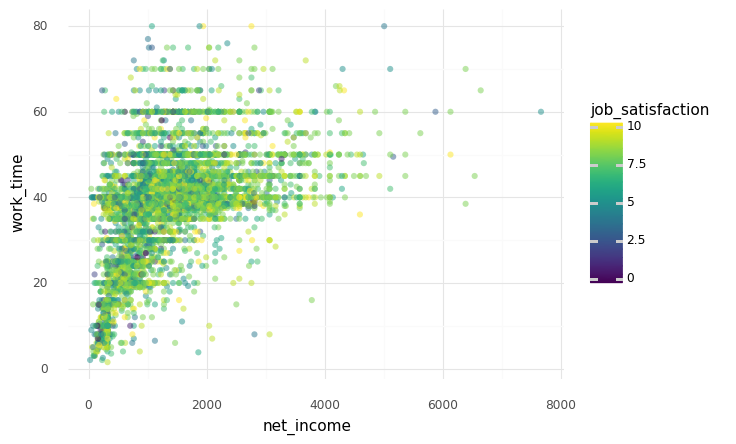

<ggplot: (8788334907576)>

In [12]:
# Effects of income and working hours on job satisfaction
(ggplot (good_job_final, aes(x = 'net_income', y = 'work_time', fill = 'job_satisfaction')) + 
 geom_point(color = "#2ca25f", size = 2.5, stroke = 0, alpha = 0.5) +
 theme_minimal())

Many subjective job features are statically significant. Employees are likely to feel more satisfied when they have good relationships with colleagues, a low number of conflicts with seniors, more opportunities to learn, and more variety of assigned. In contrast, too much stress at work and hazardous working conditions are negatively associated with job satisfaction. Other variables in the group are statically insignificant, including high levels of manual tasks, special working shifts, and high risks of accidents. 

The results also show that many socio-demographic features affect job satisfaction. Gender is a key determinant as the numbers indicate that male workers are more satisfied than female counterparts. Concerning the level of monthly net household income, originating from more affluent families tend to increase workers' satisfaction at work. Another interesting finding is that people with a migration background are more satisfied than native German employees. In contrast, more years of education and training reduce job satisfaction, which can be explained by their higher expectations or aspirations for their careers. Surprisingly, there is no statically significant difference between different age groups.

Most personality variables are statistically significant. Both neuroticism features have a strong effect on the dependent variable as those people who cannot deal well with stress and worry frequently tend to feel more dissatisfied at work. The same holds true for conscientiousness: levels of job satisfaction are higher in those workers who can work thoroughly and efficiently. Concerning agreeableness, only forgiveness has a statically significant effect, while friendliness is not a key determinant of job satisfaction. Openness to experience (represented by a lively imagination) is statically significant for individual satisfaction at work. Both extraversion variables, namely reserved and sociable, are not statically significant to job satisfaction. 

# Canonical correlation analysis
## Theory

Canonical correlation analysis (CCA) is a statistical technique that helps determine possible relationships between two sets of variables. 

Let consider two sets of variables: $X = (X_1,…, X_p)$ and $Y = (Y_1,…, Y_q)$. The simplest way to examine their relationships is to look at the correlation matrix between them. However, when p and q are large, it results in the following graph, which can be difficult and time-consuming to interpret.

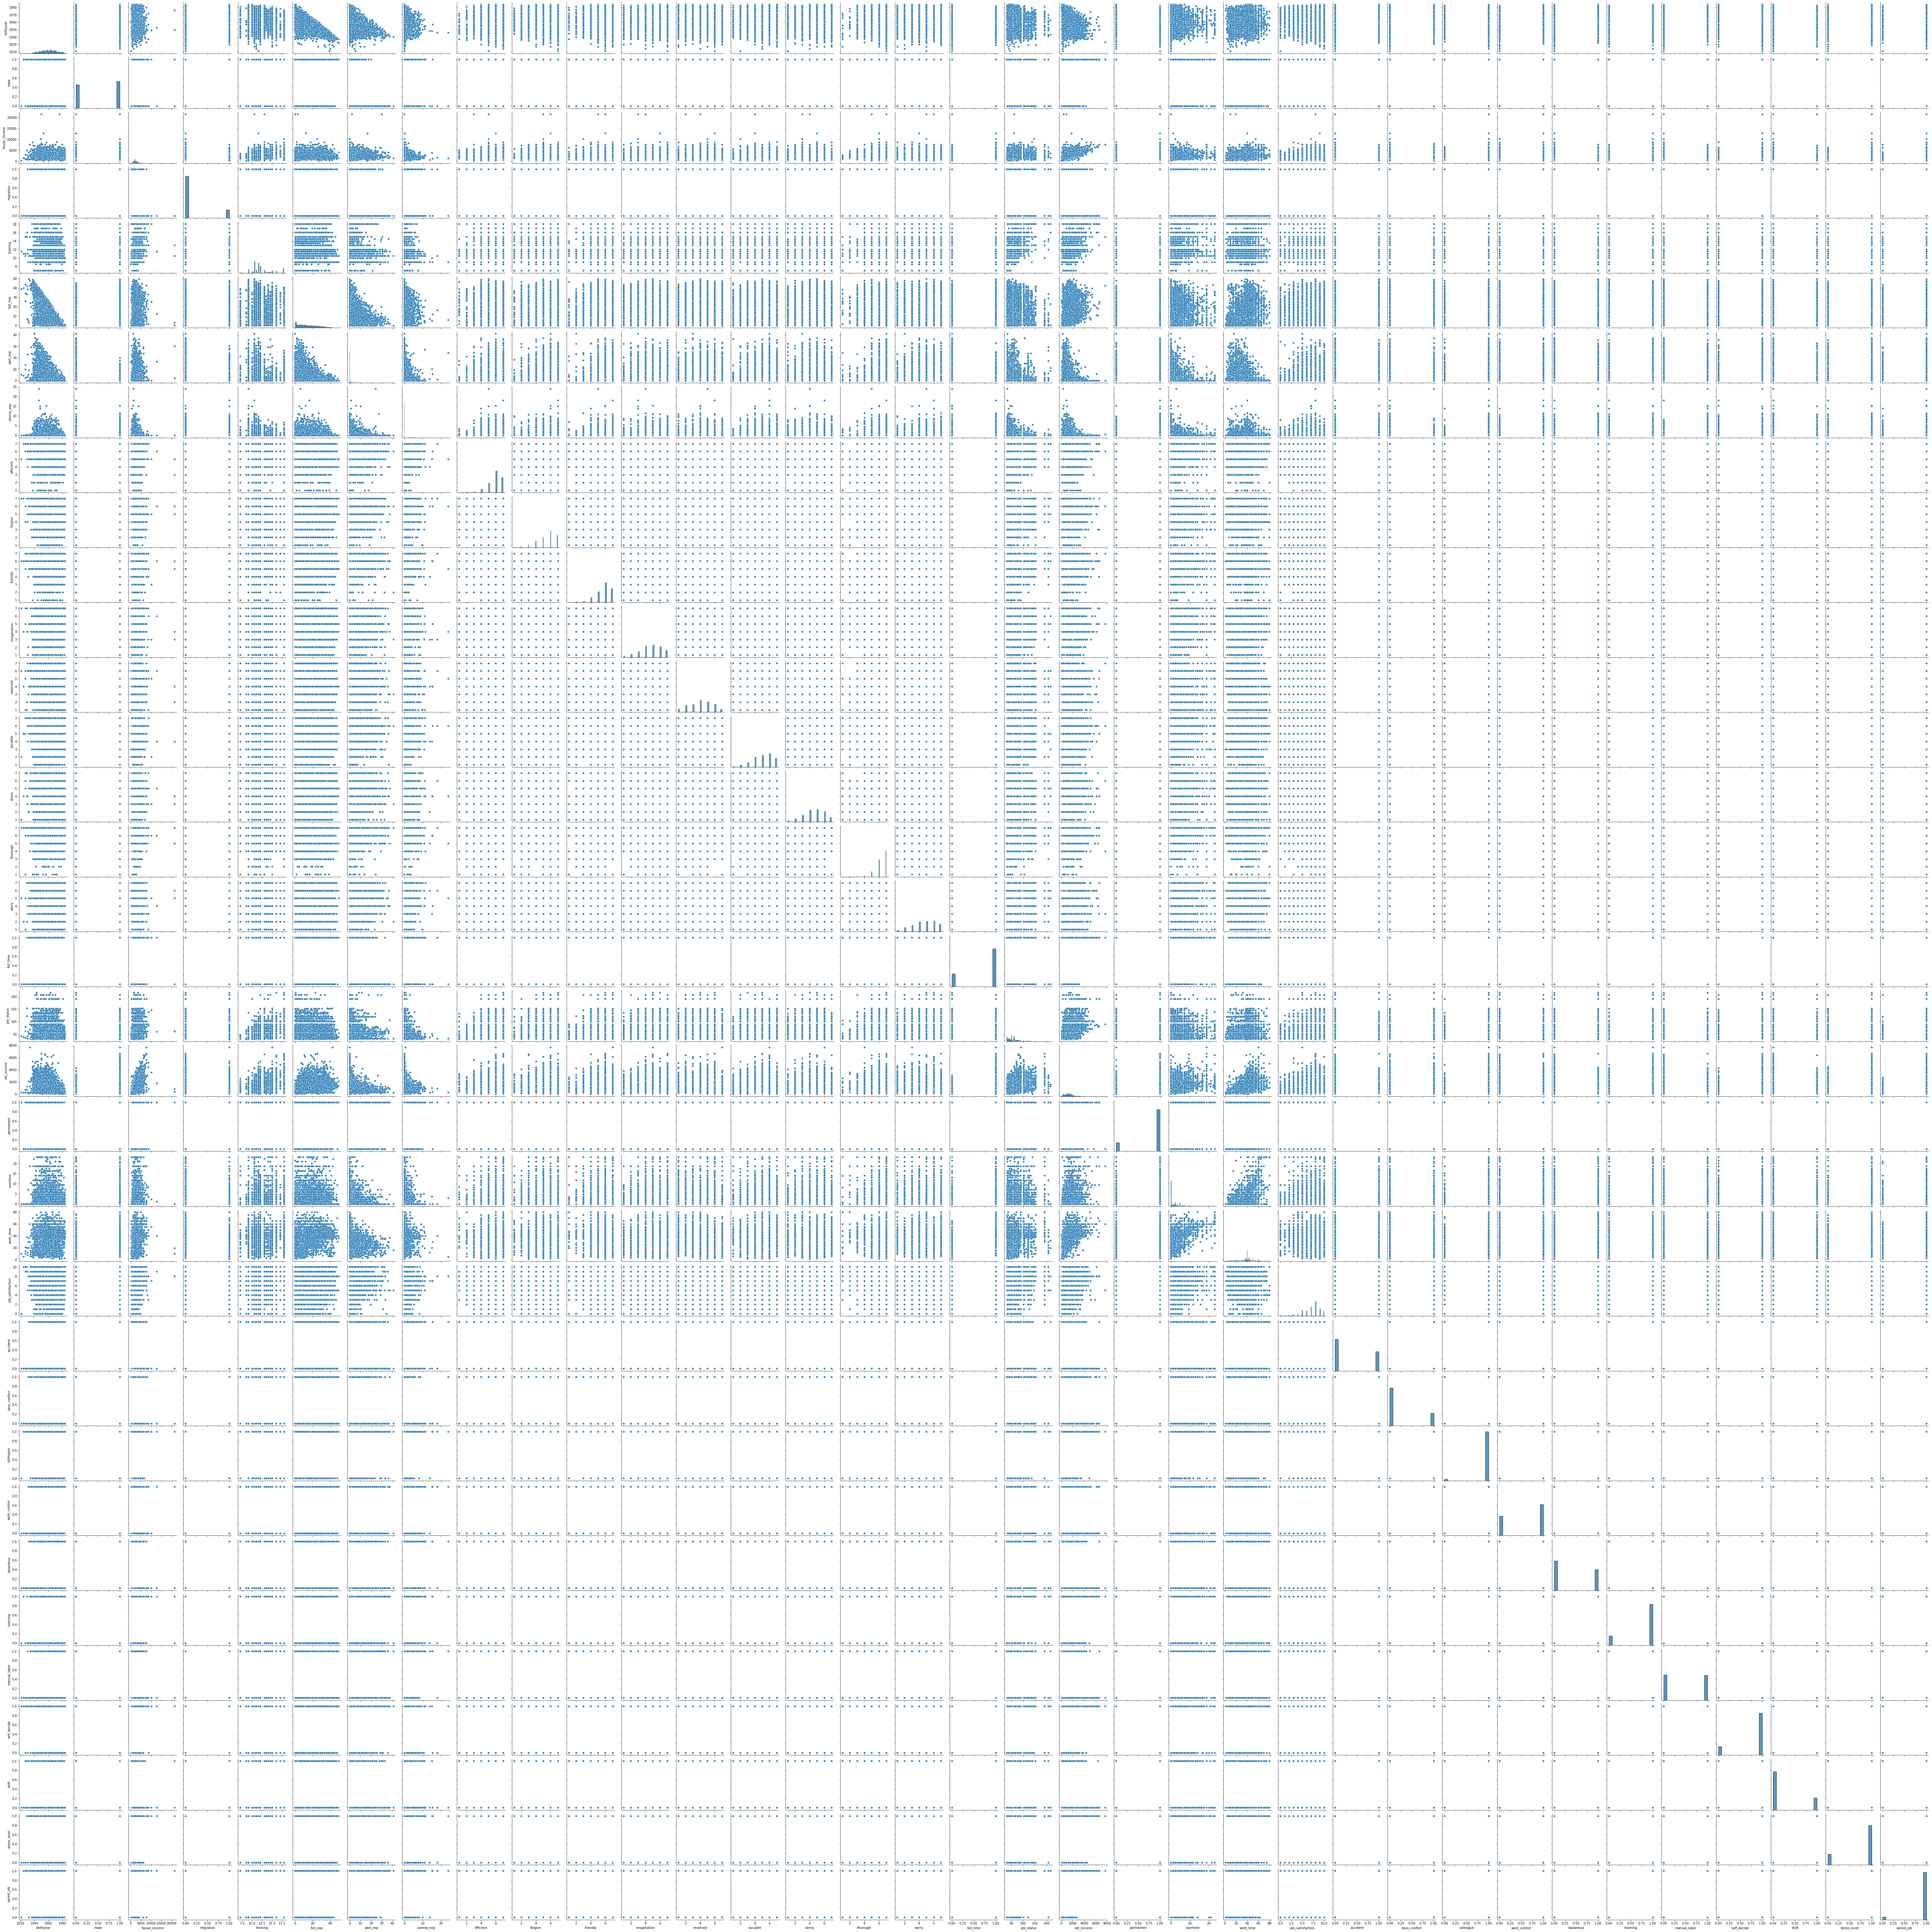

In [35]:
sns.pairplot(good_job_final)

CCA helps resolve this problem by examining the inter-correlations between the two sets rather than the correlation between each variable in both sets. The objective is to acquire a smaller number of derived canonical variables that represent high correlations between the two groups.

To implement CCA, let $U_m = a_{m1}X_1 + … + a_{mp}X_p$ and $V_m = b_{m1}Y_1 + … + b_{mq}Y_q$ are linear combinations of all variables in set X and Y, respectively. 

We need to find $U_1 = a_{11}X_1 + … + a_{1p}X_p$ and $V_1 = b_{11}Y_1 + ... + b_{1q}Y_q $, such that the correlation between them $\rho_1$ = corr ($U_1$, $V_1$) is the largest possible across all combination weights for $U_1$ and $V_1$.  $U_1$ and $V_1$ are the first pair of canonical correlation variables, and $\rho_1$ is called the first canonical correlation. We continue the process until a total of k = min (p, q) pairs of canonical variables and corresponding correlations are acquired. 

In general, we need to find vectors a and b to maximize $\rho(a,b)$, with

$\rho(a,b) = \frac{a'\Sigma_{12}b}{(a'\Sigma_{11}a)(b'\Sigma_{22}b)^{1/2}}$

with Σ be the cross-covariance matrix of U and V. This maximization problem can be solved by applying the Lagrange multiplier method.

There are two ways to interpret CCA results: 
- Standardized canonical coefficients: both their magnitude and sign indicate the contribution of original variable to the construction of a canonical variable. However, they can be unreliable, especially when the sample sizes are small and variables are multicollinear.
- Canonical loadings, which refer to the correlations of original variables and corresponding canonical variable within the set. For instance, the correlations between $U_1$ with each variable in the set $X = (X_1, ... X_p)$ constitute the first set of canonical loadings.

## Links between objective and subjective job features

To avoid bias due to scale differences, all data should be standardized to have a mean of zero and a standard deviation of one. 

In [13]:
good_job_std = pd.DataFrame(StandardScaler().fit_transform(good_job_final))

# Select objective and subjective job features
obj_feature = good_job_std.iloc[:, 17:23]
sub_feature = good_job_std.iloc[:, 23:]
obj_sub_CCA = CCA().fit(obj_feature, sub_feature)

The results can be seen in this [table](https://drive.google.com/file/d/15LTEY5icxaX2Pkx9vRppRheqMN9FShmV/view?usp=sharing). Thereare 6 canonical correlations between 6 objective and 12 subjective job features. All of these are statistically significant. However, it is worth noting that even small correlations would be statistically significant for large sample sizes. Therefore, I only attempt to interpret the first two correlations and ignore the others due to very weak associations. 

The first canonical correlation is 0.56, which suggests a relatively strong link between the first two canonical variables. The level of net income and job status are the two main components of $U_1$, while $V_1$ is primarily comprised of physical conditions at work, such as high risks of accidents, hazardous working conditions, and manual tasks, which have different signs with levels of job satisfaction. Overall, the first pair indicates that individuals with low-prestige jobs and lower income levels are more likely to work in poorer conditions with high risk of accidents, manual labor, and hazardous environments. They are fairly dissatisfied with their job.


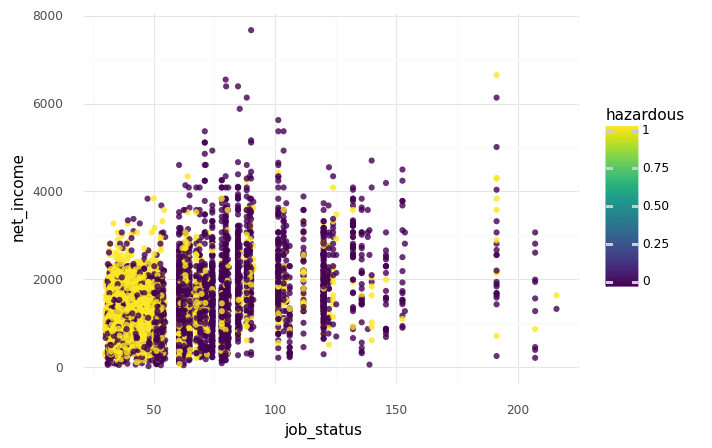

<ggplot: (8788282235233)>

In [14]:
# Low income and low-prestige jobs are linked to poorer working conditions
(ggplot (good_job_final, aes(x = 'job_status', y = 'net_income', fill = 'hazardous')) + 
 geom_point(size = 2.5, stroke = 0, alpha = 0.8) +
 theme_minimal())

In the second pair, $U_2$ includes the number of working hours, overtime hours, levels of net income, and full-time positions. All of these components have the same sign and contrast with job status. In general, the canonical $U_2$ represent individuals in lower-than-average prestige jobs who are employed in full-time positions, have high levels of net income, and have to work for long hours per week. The working conditions of the workers are likely to involve high stress levels, hazardous environments, and high risks of accidents, which are the main contributors of $V_2$. Concerning their well-being, they are slightly dissatisfied with their job.

## Links between socio-demographic and job characteristics

Based on the [results](https://drive.google.com/file/d/1MW7Q77AkfBHALWScawujtMMYH-PkUDRl/view?usp=sharing), 4 out of 8 pairs of canonical variables provide us with insights into working conditions in different socio-demographic groups. 

In [49]:
# Select socio-demographic and job features
socio_feature = good_job_std.iloc[:, :8]
job_feature = good_job_std.iloc[:, 17:]
socio_job_CCA = CCA().fit(socio_feature, job_feature)

In the first pair represents well-educated or well-trained workers. Two canonical variables $U_1$ and $V_1$ are strongly correlated (0.729). The level of education and household income are the main components of $U_1$, which indicates that male and young people who come from affluent families are more well-educated or well-trained. In contrast, the level of personal income, job status, number of working hours, and full-time positions are the main constituents of $V_1$. Overall, the first pair suggests that people with low levels of training and household income tend to have jobs with lower income, part-time contracts, more working hours, and low prestige. They are relatively dissatisfied with their job.


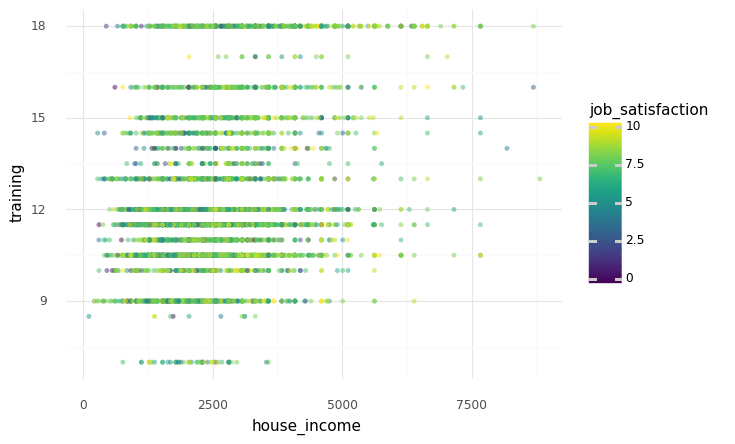

<ggplot: (8788283563740)>

In [15]:
# Associations of training time, house income, and job satisfaction
(ggplot (good_job_final, aes(x = 'house_income', y = 'training', fill = 'job_satisfaction')) + 
 geom_point(color = "#2ca25f", size = 2, stroke = 0, alpha = 0.5) +
 theme_minimal())

Gender and total part-time experiences are the main components of $U_2$. The opposite signs denote that women tended to accept part-time jobs. The other canonical variable $V_2$ is mainly comprised of full-time positions, job status, the total number of working hours, level of monthly net personal income, manual labor, risk of accident, and hazardous conditions. We may conclude that female workers are more likely to have part-time jobs with low income levels, short working time, low risk of accidents, safe working conditions, and low manual tasks. The link is quite strong with a correlation of 0.67.

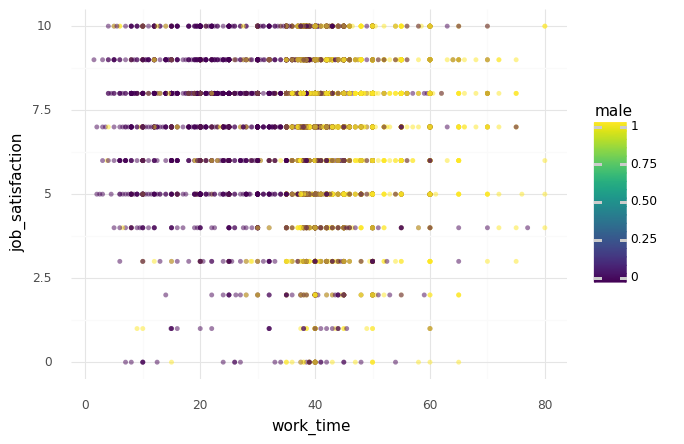

<ggplot: (8788284626993)>

In [16]:
# Associations of gender, working time, and job satisfaction
(ggplot (good_job_final, aes(x = 'work_time', y = 'job_satisfaction', fill = 'male')) + 
 geom_point(color = "#2ca25f", size = 2, stroke = 0, alpha = 0.5) +
 theme_minimal())

The third pair provides an insight into working conditions in different age groups. Overall, younger workers have fewer experiences in full-time and part-time positions than older employees. The association between $U_3$ and $V_3$ proposes that these individuals tend to work in positions with lower levels of net income, temporary contracts, more opportunities to participate in training and development programs, as well as more diverse tasks at work.

The fifth pair is about migrant employmes. $U_1$ is dominated by the migration background, suggesting that these individuals tend to be male, old, have more years unemployment, and fewer years in full-time jobs than others. Overall, they tend to be relatively satisfied with their job. 


# K-means clustering

## Theory

In this part, I use K-means clustering to split participants into groups based on their personality traits and level of job satisfaction. To understand the intuition behind this technique, let $I = (I_1, ..., I_N)$ denotes the set of individuals in the analysis sample (N = 7,506). Based on $p=10$ clustering variables, the objective is to split $I$ into $k$ clusters $C_1, ... C_k$, where $k$ is pre-specified. The final resutls should satisfy the following conditions:

- Clusters should be non-overlapping and distinct. 
- Individuals in each cluster should be similar to each other in regard to clustering features

The key to cluster analysis is to choose a suitable way to measure the degree of similarity between individuals. The most common approach involves the use of Euclidean distance, which helps measure how close one individual is to the cluster center. Ideally, the sum of all distances in each cluster should be as small as possible. This is the notion behind within-cluster variation $W(C_k)$, defined as follows:

$W(C_k) = \frac{1}{|C_k|}\sum\limits_{i,i' \in C_k}\sum\limits_{j = 1}^{p}(x_{ij}-x{i'j})^2$

where $|C_k|$ represents the number of individuals in the cluster $C_k$ and the latter sum denotes the Euclidean distance between point i and i' for p variables. Within-cluster variation measures the compactness of clustering. It allows us to quantify the differences between individuals in a cluster. 

The objective of K-means clustering is to minimize the total within-cluster variation over all clusters in the sample.

$$\underset{C_1,...C_k}{minimize}{\sum\limits_{k = 1}^{K}W(C_k)}$$

Some K-means clustering algorithms are available to solve this optimization problem. In this project, I follow the standard approach suggested by Hartigan and Wong (1979).

## Implementation

In [24]:
clust = good_job_std.iloc[:, np.r_[8:17,23]]
kmeans = KMeans(n_clusters=3)
test = kmeans.fit(clust)

(pd.DataFrame(test.cluster_centers_)
     .transpose()
     .set_axis(['Cluster 1', 'Cluster 2', 'Cluster 3'], axis = 1)
     .set_axis(clust.columns, axis = 0)
     .style.background_gradient(cmap = 'Blues', vmin = -1, vmax = 1))

Overall, three well-separated groups are determined. 

Cluster 1 includes individuals with many positive qualities of employees. They are very sociable and less reserved, very imaginative, friendly and able to forgive other people easily, work efficiently and thoroughly, and able to deal with stress well and less worried. These individuals are relatively satisfied with their occupation.

Cluster 2 appears to be an inferior version of cluster 1. They have many positive features, namely efficiency, thoroughness, forgiveness, and friendliness, but the cluster means are lower than those in the first group. Conversely, the signs of neuroticism and openness variables contrasted with those in group 1. This indicates they are not so imaginative, worry a lot, and cannot cope with stress well. Group 2 also has a low score of extraversion as they are less sociable and more reserved. The level of job satisfaction is low in this cluster. 

Cluster 3 represents individuals with almost opposite personality traits to those in the first group. They work very inefficiently and are not good at organizing tasks, not very imaginative, very unfriendly and unwilling to show affection to others, do not worry a lot about work-related matters, and lack capabilities to handle stress. Overall, this group includes respondents with negative features and a relatively low level of job satisfaction.

The following image shows us a clearer picture of these three distinctive groups. It can be observed that the three clusters are separated quite well, though there are still some overlaps between them.

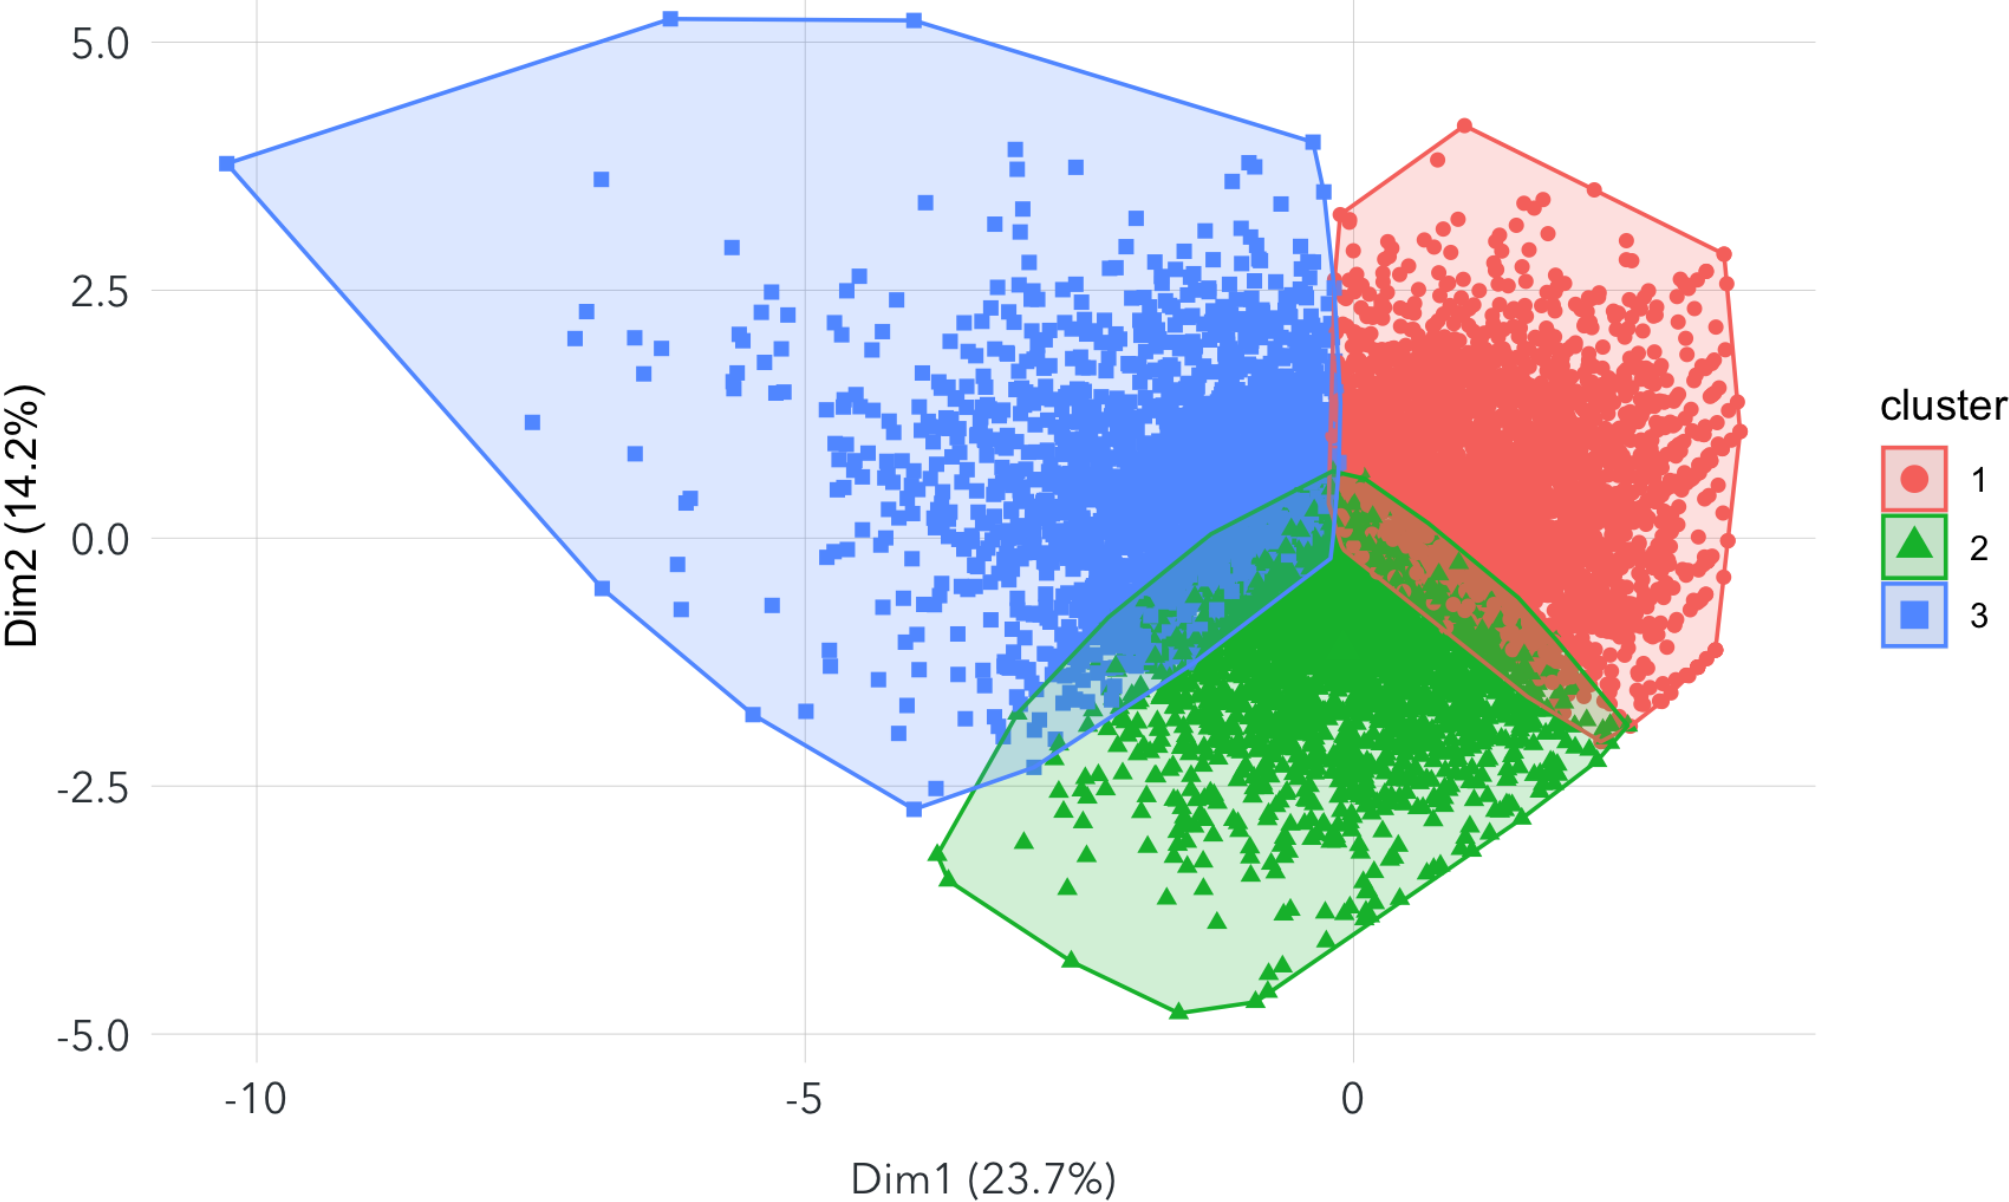

# Conclusion

- Money is not the only thing that people value in a high-quality job. Non-pecuniary aspects of work, such as job security, working hours, learning opportunities, relationships with colleagues, control, stress, task variety, and working conditions, play an important role as well.
- The notion of a "good" or "bad" job is subjective to personality traits and socio-demographic backgrounds.
- There are strong interactions between components of job quality, which implicates that we should interpret them together when measuring their roles. From a practical perspective, organizations should take multi-pronged approaches to improve job quality rather than putting too much importance on financial factors. 
- For employed individuals, it is important to choose a position that suits their capabilities, personal circumstances, and career expectations. 